## Import predictor variables

In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Temperature difference
diffs = pd.read_csv('./bd_ayuntamiento/diff.csv', delimiter=',')
diffs.head()

,station,temp_diff,lat,lon
0,1,1.396381,41.653858,-0.876258
1,2,1.320874,41.649671,-0.884855
2,3,1.069900,41.660269,-0.871698
3,4,1.115054,41.646083,-0.900292
4,5,1.633224,41.650508,-0.904937


In [3]:
# Get stations
stations = pd.read_csv('./bd_ayuntamiento/posicion.csv', delimiter=';')
stations.columns = ['code', 'lat', 'lon', 'x', 'y']
stations.head()

,code,lat,lon,x,y
0,S01,41.6538,-0.876258,676837.98,4613524.38
1,S02,41.6496,-0.884854,676133.56,4613041.96
2,S03,41.6602,-0.871698,677200.12,4614245.63
3,S04,41.6460,-0.900291,674857.72,4612612.12
4,S05,41.6505,-0.904937,674458.88,4613093.96


In [4]:
stations['station'] = stations['code'].str.extract(r'(\d+)', expand=False).astype(int)
stations = stations.drop(columns=['code', 'lat', 'lon'])
stations.head()

,x,y,station
0,676837.98,4613524.38,1
1,676133.56,4613041.96,2
2,677200.12,4614245.63,3
3,674857.72,4612612.12,4
4,674458.88,4613093.96,5


In [5]:
# Move 'station' to the first position
columns = ['station'] + [col for col in stations.columns if col != 'station']
stations = stations[columns]
stations.columns = ['station', 'x', 'y']
stations.head()

,station,x,y
0,1,676837.98,4613524.38
1,2,676133.56,4613041.96
2,3,677200.12,4614245.63
3,4,674857.72,4612612.12
4,5,674458.88,4613093.96


In [6]:
df = stations
df.head()

,station,x,y
0,1,676837.98,4613524.38
1,2,676133.56,4613041.96
2,3,677200.12,4614245.63
3,4,674857.72,4612612.12
4,5,674458.88,4613093.96


In [7]:
# Go to raster directory
raster_dir = '../data/rasters'
os.chdir(raster_dir)

In [8]:
# List all .tif files
list = glob.glob('*.tif')
list

['Zaragoza_ETRS89_NDTI.tif',
 'Zaragoza_ETRS89_NDVI_scaled_old.tif',
 'interpolation_SVF+IMD+NDVI_scaled.tif',
 'Zaragoza_ETRS89_NDVI_scaled.tif',
 'Zaragoza_ETRS89_MDS05.tif',
 'Zaragoza_ETRS89_LST_LC09_20230815_normalized.tif',
 'Zaragoza_ETRS89_MDT05.tif',
 'Zaragoza_ETRS89_SWIR2_normalized_scaled.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled.tif',
 'Zaragoza_ETRS89_Terrain_Ruggedness_Index.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled_old.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled_old.tif',
 'Zaragoza_ETRS89_Sky_View_Factor.tif',
 'predictors_skf_imd_ndvi.tif',
 'Zaragoza_ETRS89_SWIR2.tif',
 'Zaragoza_ETRS89_SWIR2_normalized.tif',
 'Zaragoza_ETRS89_MDT05_normalized.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled.tif',
 'Zaragoza_ETRS89_GLI.tif',
 'Zaragoza_ETRS89_NBAI.tif',
 'Zaragoza_ETRS89_LST_LC09_20230815.tif',
 'Zaragoza_ETRS89_Total_Insolation.tif',
 'Zaragoza_ETRS89_Visible_Sky

EPSG:25830


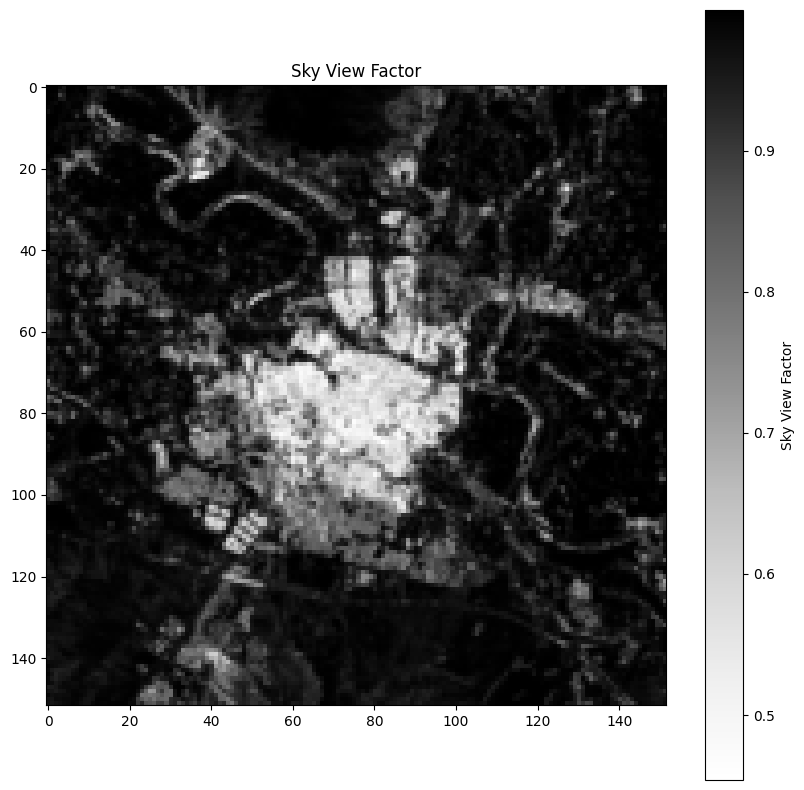

In [9]:
svf_raster_path = 'Zaragoza_ETRS89_Sky_View_Factor_scaled.tif'
with rasterio.open(svf_raster_path) as src:
    print(src.crs)
    svf = src.read(1)

    # Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])

    lons, lats = coords[:, 0], coords[:, 1]

    # Get SVF values
    svfs = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        svf_value = src.read(1)[row, col]
        svfs.append(svf_value)
    df['svf'] = svfs
    
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

In [10]:
df.head()

,station,x,y,svf
0,1,676837.98,4613524.38,0.598333
1,2,676133.56,4613041.96,0.599017
2,3,677200.12,4614245.63,0.683624
3,4,674857.72,4612612.12,0.702197
4,5,674458.88,4613093.96,0.588549


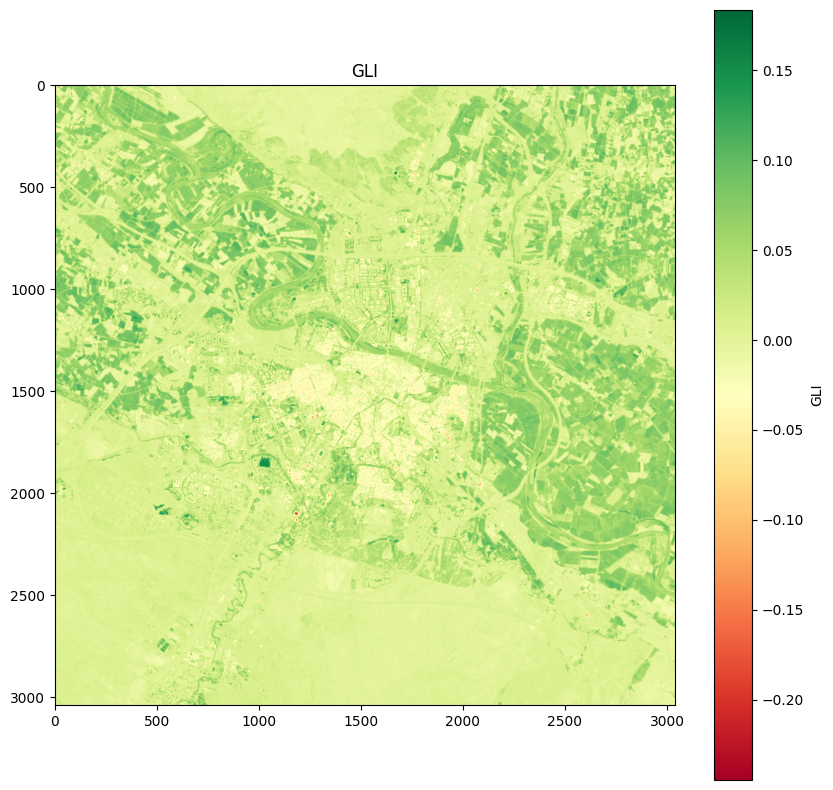

In [11]:
gli_raster_path = 'Zaragoza_ETRS89_GLI.tif'
scale = 2
with rasterio.open(gli_raster_path) as src:
    #gli = src.read(1)
    gli = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get GLI values
    glis = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        gli_value = gli[row, col]
        glis.append(gli_value)
    df['gli'] = glis
    
plt.figure(figsize=(10, 10))
plt.imshow(gli, cmap='RdYlGn')
plt.colorbar(label='GLI')
plt.title(f'GLI')
plt.show()

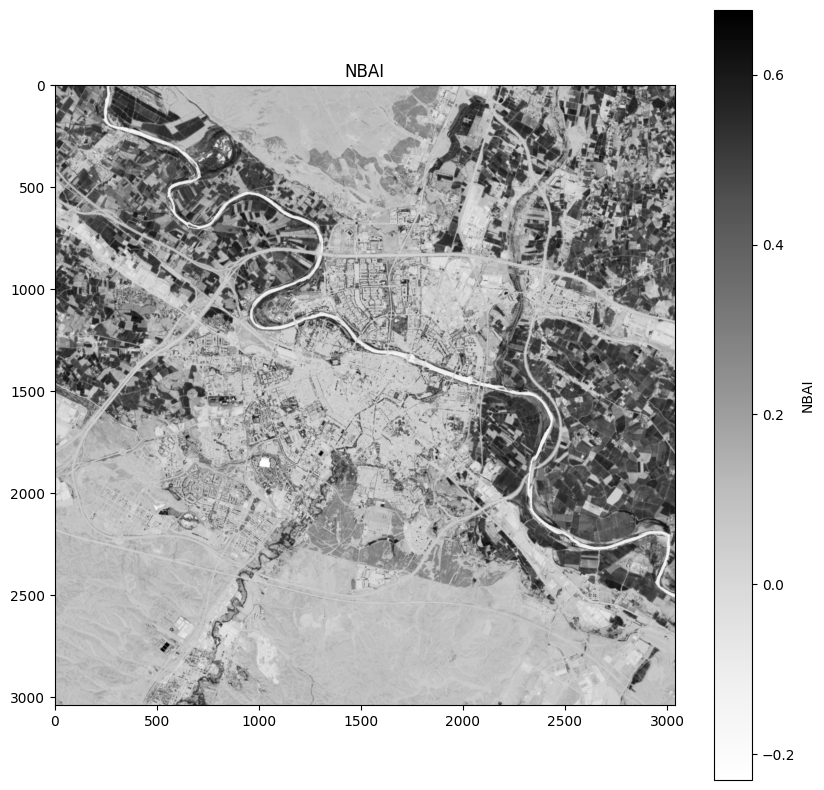

In [12]:
nbai_raster_path = 'Zaragoza_ETRS89_NBAI.tif'
with rasterio.open(nbai_raster_path) as src:
    #imd = src.read(1)
    nbai = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NBAI values
    nbais = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        nbai_value = nbai[row, col]
        #print(imd_value)
        #print(imd_value)
        nbais.append(nbai_value)
    df['nbai'] = nbais
    
plt.figure(figsize=(10, 10))
plt.imshow(nbai, cmap='Grays')
plt.colorbar(label='NBAI')
plt.title(f'NBAI')
plt.show()

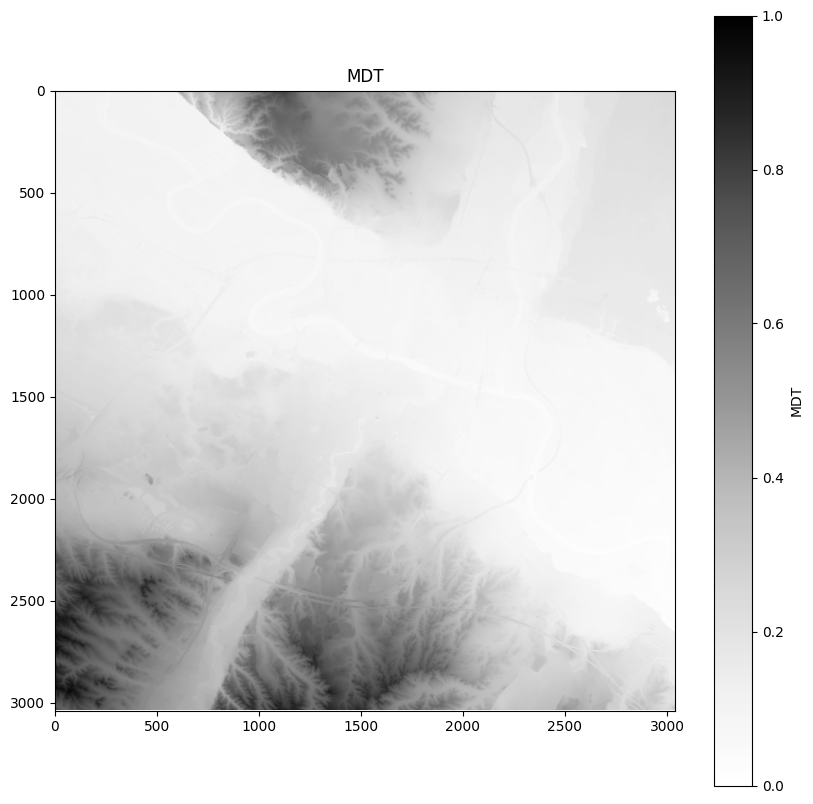

In [13]:
mdt_raster_path = 'Zaragoza_ETRS89_MDT05_normalized.tif'
with rasterio.open(mdt_raster_path) as src:
    mdt = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get swir2 values
    mdts = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        mdt_value = mdt[row, col]
        mdts.append(mdt_value)
    df['mdt'] = mdts
    
plt.figure(figsize=(10, 10))
plt.imshow(mdt, cmap='Grays')
plt.colorbar(label='MDT')
plt.title(f'MDT')
plt.show()

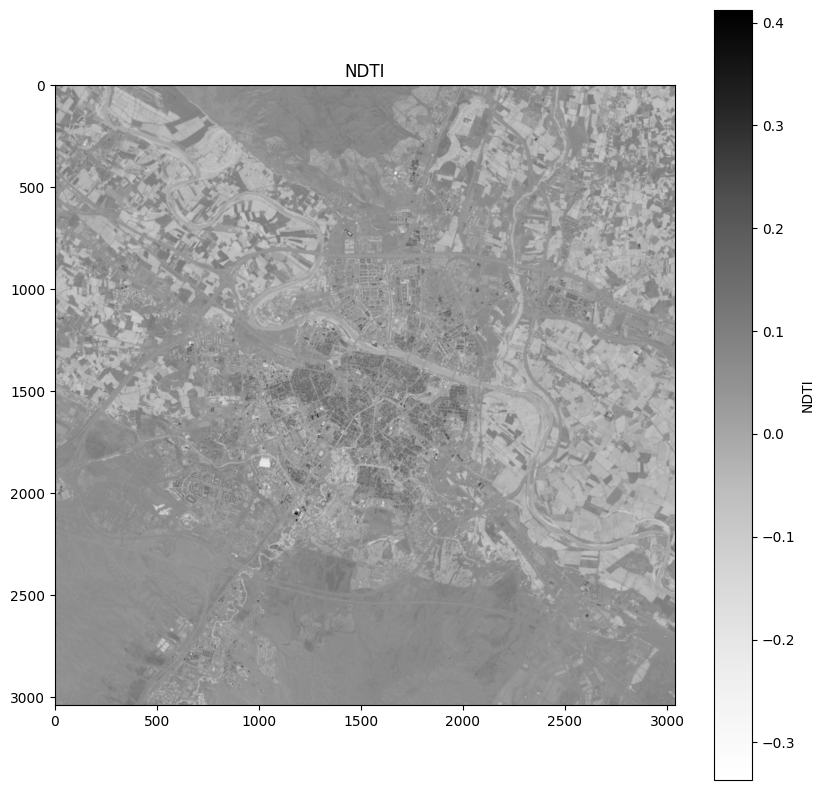

In [14]:
ndti_raster_path = 'Zaragoza_ETRS89_NDTI.tif'
with rasterio.open(ndti_raster_path) as src:
    ndti = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get swir2 values
    ndtis = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        ndti_value = ndti[row, col]
        ndtis.append(ndti_value)
    df['ndti'] = ndtis
    
plt.figure(figsize=(10, 10))
plt.imshow(ndti, cmap='Grays')
plt.colorbar(label='NDTI')
plt.title(f'NDTI')
plt.show()

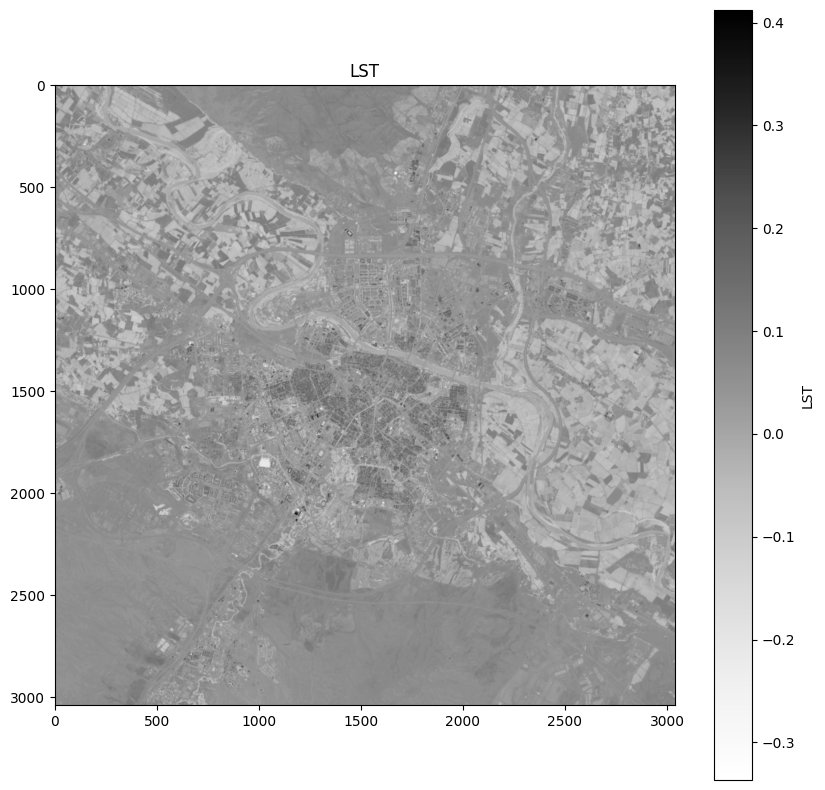

In [15]:
lst_raster_path = 'Zaragoza_ETRS89_LST_LC09_20230815_normalized.tif'
with rasterio.open(lst_raster_path) as src:
    lst = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get swir2 values
    lsts = []
    for index, station in stations.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Read the value of the pixel
        lst_value = lst[row, col]
        lsts.append(lst_value)
    df['lst'] = lsts
    
plt.figure(figsize=(10, 10))
plt.imshow(ndti, cmap='Grays')
plt.colorbar(label='LST')
plt.title(f'LST')
plt.show()

In [16]:
df.head()

,station,x,y,svf,gli,nbai,mdt,ndti,lst
0,1,676837.98,4613524.38,0.598333,0.069574,0.485734,0.118479,-0.030730,0.377976
1,2,676133.56,4613041.96,0.599017,-0.007472,0.178041,0.135812,0.090028,0.418029
2,3,677200.12,4614245.63,0.683624,-0.014394,0.144677,0.084033,0.101110,0.203002
3,4,674857.72,4612612.12,0.702197,0.021348,0.215104,0.179151,0.048411,0.380759
4,5,674458.88,4613093.96,0.588549,0.048385,0.404729,0.174195,0.005247,0.297898


## Add temperature differences

In [17]:
df = df.drop(columns=['x', 'y'])
df.head()

,station,svf,gli,nbai,mdt,ndti,lst
0,1,0.598333,0.069574,0.485734,0.118479,-0.030730,0.377976
1,2,0.599017,-0.007472,0.178041,0.135812,0.090028,0.418029
2,3,0.683624,-0.014394,0.144677,0.084033,0.101110,0.203002
3,4,0.702197,0.021348,0.215104,0.179151,0.048411,0.380759
4,5,0.588549,0.048385,0.404729,0.174195,0.005247,0.297898


In [18]:
# Remove reference station
#df = df[df['station'] != 19]
#df.head()

In [19]:
#diffs = diffs.drop(columns=['lat', 'lon'])
#diffs.head()

In [20]:
df = pd.merge(df, diffs, on='station', how='inner')
df.head()

,station,svf,gli,nbai,mdt,ndti,lst,temp_diff,lat,lon
0,1,0.598333,0.069574,0.485734,0.118479,-0.030730,0.377976,1.396381,41.653858,-0.876258
1,2,0.599017,-0.007472,0.178041,0.135812,0.090028,0.418029,1.320874,41.649671,-0.884855
2,3,0.683624,-0.014394,0.144677,0.084033,0.101110,0.203002,1.069900,41.660269,-0.871698
3,4,0.702197,0.021348,0.215104,0.179151,0.048411,0.380759,1.115054,41.646083,-0.900292
4,5,0.588549,0.048385,0.404729,0.174195,0.005247,0.297898,1.633224,41.650508,-0.904937


In [21]:
df.shape

(21, 10)

In [22]:
df.to_csv('../../zaragoza/data.csv', index=False)

## Kriging

In [27]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pykrige.uk import UniversalKriging
from pyproj import Transformer

In [ ]:
'''# Flatten the coordinates and raster bands
lons = lons.flatten()
lats = lats.flatten()
svf = svf.flatten()
ndvi = ndvi.flatten()
imd = imd.flatten()
swir2 = swir2.flatten()'''

In [ ]:
#df = pd.DataFrame()

In [ ]:
'''df['svf'] = svf
df['imd'] = imd
df['ndvi'] = ndvi
df['swir2'] = swir2
df['lat'] = lats
df['lon'] = lons'''

In [ ]:
predictors = ['svf']
X = df[predictors].values
y = df['temp_diff'].values

In [ ]:
'''# Transform coordinates from ETRS89 to WRS84
transformer = Transformer.from_crs('EPSG:25830', 'EPSG:4326')
lats, lons = transformer.transform(df['lat'], df['lon'])
coordinates = np.stack((lats, lons), axis=1)
coordinates'''

coordinates = df[['lat', 'lon']].values

### Using Hyperopt

In [ ]:
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [ ]:
# Define the search space
search_space = {
    'variogram_model': hp.choice('variogram_model', ['linear', 'power', 'gaussian', 'exponential', 'spherical']),
    'drift_terms': hp.choice('drift_terms', [
        ['regional_linear'],
        ['regional_quadratic'],
        ['regional_linear', 'regional_quadratic']
    ])
}

In [ ]:
# Define the kriging cross-validation function
def kriging_cv(X, y, coordinates, variogram_model, drift_terms):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coord_train, coord_test = coordinates[train_index], coordinates[test_index]

        # Create the Kriging model
        kriging_model = UniversalKriging(
            coord_train[:, 0], coord_train[:, 1], y_train,
            external_drift=X_train,  # Include external drift data
            variogram_model=variogram_model,
            drift_terms=drift_terms
        )

        # Predict test data
        y_pred = [kriging_model.execute('points', x[0], x[1])[0] for x in coord_test]
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [ ]:
# Objective function for Hyperopt
def objective(params):
    variogram_model = params['variogram_model']
    drift_terms = params['drift_terms']

    # Call the kriging cross-validation function
    rmse = kriging_cv(X, y, coordinates, variogram_model, drift_terms)
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# Best parameters
print('Best parameters:', best_params)

### Rendering results

In [ ]:
from matplotlib.colors import Normalize
from branca.colormap import linear
import folium

In [ ]:
def kriging_cv2(X, y, coordinates):
    # Set cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coord_train, coord_test = coordinates[train_index], coordinates[test_index]

        kriging_model = UniversalKriging(
            coord_train[:, 0], coord_train[:, 1], y_train,
            external_drift=X_train,  # Include external drift data
            variogram_model='spherical',
            drift_terms=['regional_quadratic']
        )

        # Predict test data
        y_pred = [kriging_model.execute('points', x[0], x[1])[0] for x in coord_test]
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Compute RMSE
rmse_result = kriging_cv2(X, y, coordinates)
print(f'Average RMSE: {rmse_result}')

In [ ]:
# Fit and predict raster grid
def predict_raster(X, y, coordinates, extent, grid_size=100):
    lat_min, lat_max, lon_min, lon_max = extent
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_grid = np.linspace(lon_min, lon_max, grid_size)

    # Train UniversalKriging
    uk = UniversalKriging(
        coordinates[:, 0], coordinates[:, 1], y,
        external_drift=X,  # Include external drift data
        variogram_model='spherical',
        drift_terms=['regional_quadratic']
    )

    # Create grid for prediction
    lat_lon_mesh = np.meshgrid(lat_grid, lon_grid)
    lat_flat, lon_flat = lat_lon_mesh[0].ravel(), lat_lon_mesh[1].ravel()

    # Predict over the grid
    z_pred, _ = uk.execute('grid', lat_grid, lon_grid)
    return lat_grid, lon_grid, z_pred

In [ ]:
# Visualize using Folium
def plot_raster_on_map(lat_grid, lon_grid, z_pred, extent):
    lat_min, lat_max, lon_min, lon_max = extent

    # Normalize the predicted values for coloring
    norm = Normalize(vmin=z_pred.min(), vmax=z_pred.max())
    cmap = linear.viridis.scale(z_pred.min(), z_pred.max())

    # Create Folium map
    zgz_coords = (41.653858, -0.876258)
    fmap = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=12)

    for i in range(len(lat_grid) - 1):
        for j in range(len(lon_grid) - 1):
            # Create a rectangle for each grid cell
            bounds = [
                [lat_grid[i], lon_grid[j]],
                [lat_grid[i + 1], lon_grid[j + 1]]
            ]
            color = cmap(norm(z_pred[i, j]))
            folium.Rectangle(bounds, color=color, fill=True, fill_opacity=0.7).add_to(fmap)

    cmap.add_to(fmap)
    return fmap

In [ ]:
extent = [coordinates[:, 0].min(), coordinates[:, 0].max(), coordinates[:, 1].min(), coordinates[:, 1].max()]
lat_grid, lon_grid, z_pred = predict_raster(X, y, coordinates, extent, grid_size=200)
raster_map = plot_raster_on_map(lat_grid, lon_grid, z_pred, extent)

# Show map
raster_map